In [58]:
class SimulationParams:
    """A clean container holding all simulation parameters."""

    def __init__(self, params: dict):
        # 把所有参数写入成员变量
        for k, v in params.items():
            setattr(self, k, v)

    def __repr__(self):
        return "\n".join([f"{k} = {v}" for k, v in self.__dict__.items()])


def load_simulation_params(path):
    params = {}

    with open(path, "r") as f:
        for line in f:
            if "=" not in line:
                continue

            k, v = line.split("=")
            k = k.strip()
            v = v.strip()

            # attempt number conversion
            try:
                v = float(v) if "." in v else int(v)
            except:
                pass

            params[k] = v

    return SimulationParams(params)


In [59]:
from config_paths import OUT, FIGS
import numpy as np

param = load_simulation_params(f"{OUT}/params.txt")
print(param)          # 打印所有参数

e_SI = 1.602176634e-19 # C
m_e_SI = 9.10938356e-31 # kg
eps0_SI = 8.8541878128e-12 # F/m

# 以 1e15 m^-3 和 1 eV 作为标准参考（可以自由改成你的基准）
n0_ref  = 1.0e15    # m^-3, total density
Te_ref  = 1.0

# use ref parameter to calculate normalization scales
# plasma frequency of real n0_total in SI units
vth_ref_SI = np.sqrt(Te_ref * e_SI / m_e_SI)
omega_p_realn0_SI = np.sqrt(param.n0*n0_ref * e_SI**2 / (eps0_SI * m_e_SI))
lambdaD_realn0_SI = vth_ref_SI / omega_p_realn0_SI
print("omega_p_realn0_SI (rad/s):", omega_p_realn0_SI)
print("lambdaD_SI (m):", lambdaD_realn0_SI)


Lx = 30.0
Nx = 512
Np = 1000000
dt = 0.02
steps = 3000
v0 = 2
vth = 0.0316227766016838
n0 = 3.0
Te = 0.001
outdir = output
diag_interval = 10
phase_snap = 50
vth_ref_SI = 419382.8844972904
omega_p_SI = 1783986379.8348
lambdaD_SI = 0.00023508188696828836
dx = 0.05859375
omega_p_realn0_SI (rad/s): 3089955049.884743
lambdaD_SI (m): 0.00013572459072274648


γ_total (from energy): -5.290e+00  (1/step)


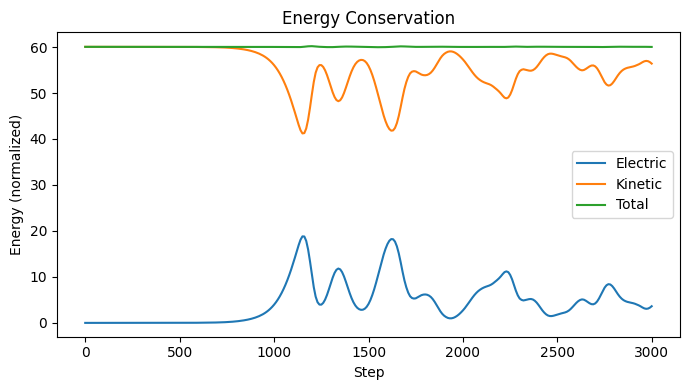

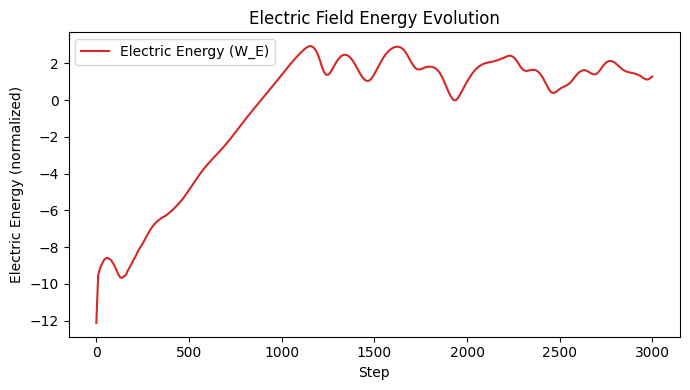

In [37]:
# diagnostics/plot_energy.py
import os, numpy as np, matplotlib.pyplot as plt
from diag_utils import ensure_dir, load_energy, robust_linear_fit
from config_paths import OUT, FIGS   # ✅ 直接导入全局路径

data = load_energy(OUT)
t, WE, WK, WT = data.T

# t = t*param.dt# /param.omega_p_SI  # 转为物理时间
# t

# -------------------------------
# 原有三条曲线：总能量图
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(t, WE, label="Electric")
plt.plot(t, WK, label="Kinetic")
plt.plot(t, WT, label="Total")
plt.xlabel("Step"); plt.ylabel("Energy (normalized)")
plt.title("Energy Conservation")
plt.legend(); plt.tight_layout()
# plt.savefig(os.path.join(FIGS, "energy_evolution.png"), dpi=150)


# -------------------------------
# 拟合增长率（线性阶段）
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(t, np.log(WE), color='tab:red', label="Electric Energy (W_E)")
plt.xlabel("Step"); plt.ylabel("Electric Energy (normalized)")
plt.title("Electric Field Energy Evolution")
plt.legend(); plt.tight_layout()

a, b = robust_linear_fit(t, np.log(np.maximum(WE,1e-30)), frac=1/3)
gamma = 0.5*b
print(f"γ_total (from energy): {gamma:.3e}  (1/step)")


Fitted line: log(W_E) = -1.155e+01 + 1.340e-02 * t
0.006701814015311462
γ (from energy fit) = 3.351e-01  (omega_p_total)
γ (from energy fit) = 4.739e-01  (omega_pe_beam)


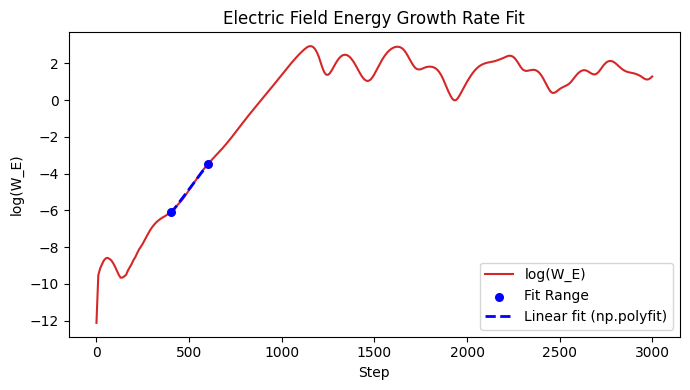

In [38]:
import math
data = load_energy(OUT)
t, WE, WK, WT = data.T
# 选择拟合区间
fit_start = 400     
fit_end   = 600      

# 转换为索引
mask = (t >= fit_start) & (t <= fit_end)

t_fit  = t[mask]
WE_fit = WE[mask]
logWE      = np.log(np.maximum(WE,     1e-30))
logWE_fit  = np.log(np.maximum(WE_fit, 1e-30))

# 绘制原始能量曲线
plt.figure(figsize=(7,4))
plt.plot(t, logWE, color='tab:red', label="log(W_E)")


# 画出拟合区间的两个端点
plt.scatter([t_fit[0], t_fit[-1]],
            [logWE_fit[0], logWE_fit[-1]],
            color='blue', s=30, zorder=5, label="Fit Range")

# 用 np.polyfit 做线性拟合：log(W_E) ≈ a + b t
# polyfit 返回 [b, a]，b 是斜率，a 是截距
b, a = np.polyfit(t_fit, logWE_fit, 1)
print(f"Fitted line: log(W_E) = {a:.3e} + {b:.3e} * t")

# 对能量来说：W_E ~ exp(2 γ t)，所以 log(W_E) ~ const + 2γ t
# 因此 b = 2γ  →  γ = b / 2
gamma = 0.5 * b # 1/step
print(gamma)

gamma = gamma / param.dt   # 1/dimensionless time unit
gamma = gamma * param.omega_p_SI / omega_p_realn0_SI  # frome omegap_ref to omegap_realn0
print(f"γ (from energy fit) = {gamma:.3e}  (omega_p_total)")
print(f"γ (from energy fit) = {gamma*np.sqrt(2):.3e}  (omega_pe_beam)")

# 拟合直线在整个 t_fit 上的值
logWE_fit_line = a + b * t_fit

# 拟合直线（虚线）
plt.plot(t_fit, logWE_fit_line,
         linestyle='--', color='blue', linewidth=2,
         label="Linear fit (np.polyfit)")

plt.xlabel("Step")
plt.ylabel("log(W_E)")
plt.title("Electric Field Energy Growth Rate Fit")
plt.legend()
plt.tight_layout()
plt.show()


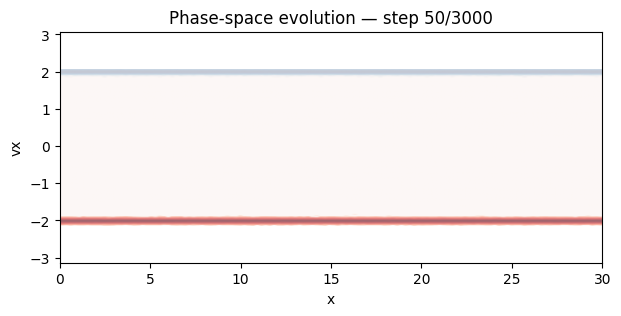

In [39]:
# diagnostics/make_phase_movie_html.py
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from diag_utils import ensure_dir
from config_paths import OUT, FIGS
from IPython.display import HTML

# 自动创建输出目录
files = sorted(glob.glob(os.path.join(OUT, "phase_*.npz")))
if not files:
    raise FileNotFoundError("❌ 未找到 phase_*.npz 文件，请先运行模拟。")

# 图设置
fig, ax = plt.subplots(figsize=(7,3))

def draw(i):
    d = np.load(files[i])

    # 获取三个 histogram（如果只存在 H_all，就退回老模式）
    if "H0" in d and "H1" in d and "H_all" in d:
        H0 = d["H0"]
        H1 = d["H1"]
        H_all = d["H_all"]
    else:
        # 老数据兼容：只有 H
        H_all = d["H"]
        H0 = None
        H1 = None

    xedges, vedges = d["xedges"], d["vedges"]

    # meta 优先（保存的 vmin/vmax）
    if "meta" in d:
        vmin, vmax, _ = d["meta"]
    else:
        vmin = vedges[0]; vmax = vedges[-1]

    ax.clear()

    # === 绘制 label=0 （蓝色流） ===
    if H0 is not None:
        ax.imshow(np.log10(H0.T + 1),
                  origin="lower",
                  extent=[xedges[0], xedges[-1], vmin, vmax],
                  aspect="auto",
                  cmap="Blues",
                  alpha=0.6)

    # === 绘制 label=1 （红色流） ===
    if H1 is not None:
        ax.imshow(np.log10(H1.T + 1),
                  origin="lower",
                  extent=[xedges[0], xedges[-1], vmin, vmax],
                  aspect="auto",
                  cmap="Reds",
                  alpha=0.6)

    # === 绘制全部背景（可选） ===
    # ax.imshow(np.log10(H_all.T + 1),
    #           origin="lower",
    #           extent=[xedges[0], xedges[-1], vmin, vmax],
    #           aspect="auto",
    #           cmap="Greys",
    #           alpha=0.2)

    ax.set_xlabel("x")
    ax.set_ylabel("vx")
    # v axis limits
    ax.set_ylim(vmin-1, vmax+1)
    ax.set_title(f"Phase-space evolution — step {(i+1)*param.phase_snap}/{param.steps}")

    return []

ani = FuncAnimation(fig, draw, frames=len(files), interval=120, blit=False)

html_path = os.path.join(FIGS, "phase_evolution.html")
html_str = ani.to_jshtml()

try:
    display(HTML(html_str))
except Exception:
    print("ℹ️ 可手动在浏览器中打开 HTML 查看动画。")

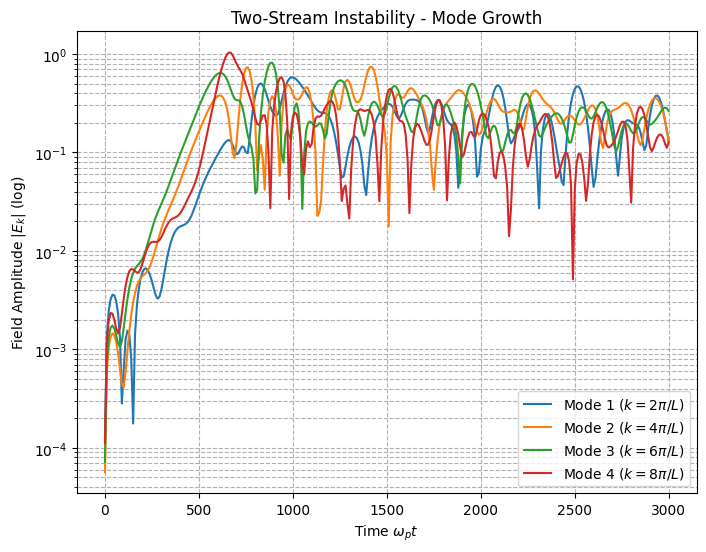

m=1:  k (1/lambdaD_total_sim) = 0.362760,   k (1/lambdaD_beam_disp) = 0.256510
m=2:  k (1/lambdaD_total_sim) = 0.725520,   k (1/lambdaD_beam_disp) = 0.513020
m=3:  k (1/lambdaD_total_sim) = 1.088280,   k (1/lambdaD_beam_disp) = 0.769530
m=4:  k (1/lambdaD_total_sim) = 1.451039,   k (1/lambdaD_beam_disp) = 1.026040


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from diag_utils import load_modes_history


data = load_modes_history(OUT)
t = data[:, 0]
mode1 = data[:, 1]
mode2 = data[:, 2]
mode3 = data[:, 3]
mode4 = data[:, 4]

plt.figure(figsize=(8, 6))
plt.semilogy(t, mode1, label='Mode 1 ($k=2\pi/L$)')
plt.semilogy(t, mode2, label='Mode 2 ($k=4\pi/L$)')
plt.semilogy(t, mode3, label='Mode 3 ($k=6\pi/L$)')
plt.semilogy(t, mode4, label='Mode 4 ($k=8\pi/L$)')
plt.xlabel('Time $\omega_p t$')
plt.ylabel('Field Amplitude $|E_k|$ (log)')
plt.title('Two-Stream Instability - Mode Growth')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

for m in range(1, 5):   # m = 1,2,3,4
    k_m = 2 * np.pi * m / param.Lx
    # from lambdaD=omegap_refn0_total/vth to omegap_realn0_toral/vth
    k_m = k_m / (1/param.lambdaD_SI) * (1/lambdaD_realn0_SI) 
    k_phys = k_m / np.sqrt(2)   # form total to beam 
    print(f"m={m}:  k (1/lambdaD_total_sim) = {k_m:.6f},   k (1/lambdaD_beam_disp) = {k_phys:.6f}")
    

Fitted line: log(W_E) = -9.039e+00 + 6.359e-04 * t
0.0006358525301950514
γ (from energy fit) = 4.496e-02  (omega_p_total)
γ (from energy fit) = 6.359e-02  (omega_pe_beam)


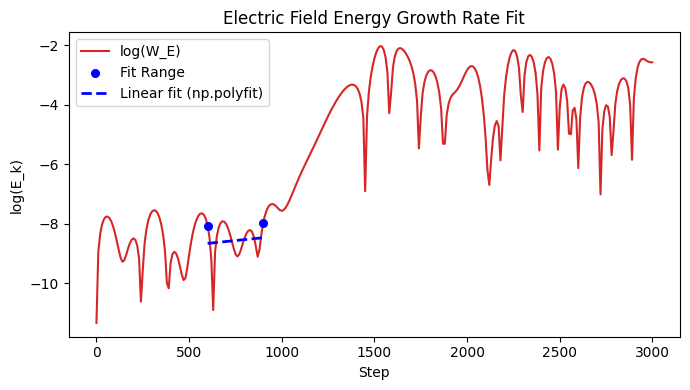

In [57]:
# 选择拟合区间
fit_start = 600      
fit_end   = 900      

# 转换为索引
mask = (t >= fit_start) & (t <= fit_end)

t_fit  = t[mask]
mode = mode3
logmode = np.log(np.maximum(mode, 1e-30))
logmode_fit = logmode[mask]
# 绘制原始能量曲线
plt.figure(figsize=(7,4))
plt.plot(t, logmode, color='tab:red', label="log(W_E)")


# 画出拟合区间的两个端点
plt.scatter([t_fit[0], t_fit[-1]],
            [logmode_fit[0], logmode_fit[-1]],
            color='blue', s=30, zorder=5, label="Fit Range")

# 用 np.polyfit 做线性拟合：log(W_E) ≈ a + b t
# polyfit 返回 [b, a]，b 是斜率，a 是截距
b, a = np.polyfit(t_fit, logmode_fit, 1)
print(f"Fitted line: log(W_E) = {a:.3e} + {b:.3e} * t")

# 对幅度来说：E_k ~ exp(γ t)，所以 log(E_k) ~ const + γ t
# 因此 b = γ
gamma =  b # 1/step
print(gamma)

gamma = gamma / param.dt   # 1/dimensionless time unit
gamma = gamma * param.omega_p_SI / omega_p_realn0_SI  # frome omegap_ref to omegap_realn0
print(f"γ (from energy fit) = {gamma:.3e}  (omega_p_total)")
print(f"γ (from energy fit) = {gamma*np.sqrt(2):.3e}  (omega_pe_beam)")

# 拟合直线在整个 t_fit 上的值
mode_fit = a + b * t_fit

# 拟合直线（虚线）
plt.plot(t_fit, mode_fit,
         linestyle='--', color='blue', linewidth=2,
         label="Linear fit (np.polyfit)")

plt.xlabel("Step")
plt.ylabel("log(E_k)")
plt.title("Electric Field Energy Growth Rate Fit")
plt.legend()
plt.tight_layout()
plt.show()


最大增长率 γ_max = 0.5000 omegap_beam_realn0
对应 k = -0.4330 (omegap_beam_realn0/vth_T=1eV)


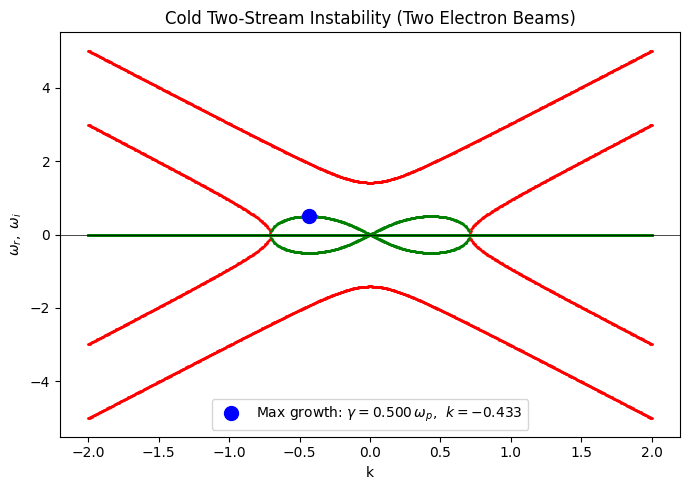

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def two_electron_stream_roots(k_array, v0=2.0, omega_p=1.0, use_beam_freq=True):
    """
    对称两电子冷流色散关系数值解：
        1 - ω_pb^2/(ω - k v0)^2 - ω_pb^2/(ω + k v0)^2 = 0

    参数
    ----
    omega_p : float
        如果 use_beam_freq=True，则 omega_p = ω_pb（单束频率）
        如果 use_beam_freq=False，则 omega_p = ω_pe（总电子频率），此时 ω_pb^2 = ω_pe^2 / 2
    """
    k_array = np.asarray(k_array)

    if use_beam_freq:
        alpha = omega_p**2          # α = ω_pb^2
    else:
        alpha = 0.5 * omega_p**2    # α = ω_pb^2 = ω_pe^2 / 2

    omegas = []
    for k in k_array:
        kv = k * v0

        a4 = 1.0
        a3 = 0.0
        a2 = -(2*kv**2 + 2*alpha)
        a1 = 0.0
        a0 = kv**4 - 2*alpha*kv**2   

        roots = np.roots([a4, a3, a2, a1, a0])
        omegas.append(roots)

    return np.array(omegas).T   # shape (4, len(k))



if __name__ == "__main__":
    # === parameters ===
    v0 = 2      # unit is vth (T=1eV)
    omega_pb = 1.0  # plasma frequency calculated from real beam electron density
    # k unit is same as the unit of omega_pb / v0, which means omega_pb/vth
    k_array = np.linspace(-2, 2.0, 800) 

    omega = two_electron_stream_roots(k_array, v0=v0, omega_p=omega_pb)
    wr = omega.real
    wi = omega.imag

    # === find maximum growth ===
    wi_pos = wi.copy()
    wi_pos[wi_pos < 0] = 0
    max_growth = wi_pos.max()
    idx_branch, idx_k = np.unravel_index(np.argmax(wi_pos), wi_pos.shape)

    # k_array = np.sqrt(2) * k_array  # convert k unit from omega_p_total/vth to omega_p_beam/vth
    k_max = k_array[idx_k]
    omega_i_max = wi_pos[idx_branch, idx_k]

    print(f"最大增长率 γ_max = {omega_i_max:.4f} omegap_beam_realn0")
    print(f"对应 k = {k_max:.4f} (omegap_beam_realn0/vth_T=1eV)")

    # === plot ===
    plt.figure(figsize=(7,5))

    # real parts
    for j in range(4):
        plt.plot(k_array, wr[j], 'r.', ms=2)

    # imaginary parts
    for j in range(4):
        plt.plot(k_array, wi[j], 'g.', ms=2)

    # highlight max growth
    plt.plot(k_max, omega_i_max, 'bo', ms=10,
             label=fr"Max growth: $\gamma={omega_i_max:.3f}\,\omega_p$,  $k={k_max:.3f}$")

    plt.axhline(0, color='k', lw=0.5)
    plt.xlabel("k")
    plt.ylabel(r"$\omega_r,\ \omega_i$")
    plt.title("Cold Two-Stream Instability (Two Electron Beams)")
    plt.legend()
    plt.tight_layout()
    plt.show()


$\omega_{p,total}=\frac{\sqrt{e^2 n_{0,total} }}{\epsilon_0 m_e} $

$\omega_{p,beam}=\frac{\sqrt{e^2 n_{0,beam} }}{\epsilon_0 m_e} = \frac{\sqrt{e^2 n_{0,total}/2 }}{\epsilon_0 m_e}=\omega_{p,total}/\sqrt{2}$

$\gamma_{(\text{unit: }\omega_{p,total})}\times \omega_{p,total}=\gamma_{(\text{unit: }\omega_{p,total})}\times \omega_{p,beam} \times \sqrt{2}=\gamma_{(\text{unit: }\omega_{p,beam})}\times \omega_{p,beam}$

$\gamma_{(\text{unit: }\omega_{p,total})} \times \sqrt{2} = \gamma_{(\text{unit: }\omega_{p,beam})}$

$\lambda_{D,sim}=\omega_{p,total}/ v_{th}=\sqrt{2} \omega_{p,beam}/(v_{th})=\sqrt{2} \lambda_{D,disp}$

$1/\lambda_{D,sim}\times \sqrt{2}=1/ \lambda_{D,disp}$

$k_{unit:1/\lambda_{D,sim}}/\sqrt{2}=k_{unit:1/\lambda_{D,disp}}$